# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import gzip
import os

Configuration

In [2]:
run_dir = Path('../../run/parallel-polaris-03Apr24153436-5d5385/')

In [3]:
Path('figures').mkdir(exist_ok=True)

## Load in all results
Get them from each "-results.json" file

In [4]:
result_files = list(run_dir.glob('*-results.json'))
print(f'Found {len(result_files)} types of result files')

Found 3 types of result files


Store the create time, start time and end time for running, and node on which they were running

In [5]:
tasks = []
for result_file in result_files:
    task_type = result_file.name.split("-")[0]
    with open(result_file) as fp:
        for line in fp:
            row = json.loads(line)
            tasks.append({
                'task_type': task_type,
                'method': row['method'],
                'create_time': row['timestamp']['created'],
                'start_time': row['timestamp']['compute_started'],
                'end_time': row['timestamp']['compute_ended'],
                'span_running': row['time']['running'],
                'node': row['worker_info']['hostname'],
                'local_rank': int(row['worker_info']['PARSL_WORKER_RANK'])
            })
tasks = pd.DataFrame(tasks)

In [6]:
print(tasks.groupby('method')['span_running'].count().to_csv())

method,span_running
run_generator,6689
run_molecular_dynamics,1468
train_generator,3



Normalize times by the time the first task was created

In [7]:
zero_time = tasks['create_time'].min()

In [8]:
time_cols = [c for c in tasks.columns if c.endswith('time')]
tasks[time_cols] -= zero_time

Assign node ids by the first time they received a task

In [9]:
node_names = []
for path in run_dir.glob('*.hosts'):
    node_names.extend([
        x.split(".")[0] for x in path.read_text().split("\n")
    ])
num_nodes = len(node_names)
print(f'Found {len(node_names)} nodes')

Found 32 nodes


In [10]:
tasks['node_id'] = tasks['node'].apply(node_names.index)

Assign a numerical task ID

In [11]:
methods = sorted(set(tasks['method']))
tasks['task_id'] = tasks['method'].apply(methods.index)

In [12]:
methods

['run_generator', 'run_molecular_dynamics', 'train_generator']

## Plot Assignment to Different Nodes
See how work is distributed.  [color pallete](https://coolors.co/f2545b-a93f55-0f7173-75f4f4-f9c22e)

In [13]:
color_map = [
    'black', # Unknown
    '#75F4F4', # Molecular Dynamics
    '#F2545B', # Generation,
    'gold',
]

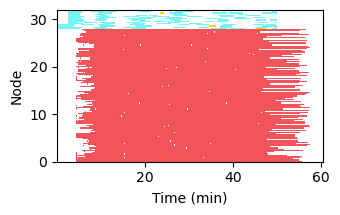

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.25))

for gid, group in tasks.groupby('method'):
    task_type = group["task_type"].iloc[0]
    c = color_map[methods.index(gid) + 1]
    height = 0.25
    offset = group['local_rank'] / 4
    ax.barh(y=group["node_id"] + offset,
            width=group["span_running"] / 60,
            left=group["start_time"] / 60,
            height=height,
            label=gid,
            color=c,
            align='edge')
            #edgecolor='k', linewidth=0.2,)
    
    
#ax.set_yticks(np.arange(len(node_names)))
ax.set_ylabel('Node')

#ax.set_xlim([2, 4])
ax.set_ylim(0, num_nodes)
ax.set_xlabel('Time (min)')
#ax.legend()
fig.tight_layout()
fig.savefig('figures/task-type-by-node.png', dpi=320)

## Summarize the GPU Utilization
Plot the amount of each GPU being used over time. Still color by task

In [16]:
utilization = []
for utilization_file in tqdm(run_dir.glob('logs/*.log')):
    # Pull in the total data
    util_data = pd.read_json(utilization_file, lines=True)
    util_data['time'] = util_data['time'].apply(lambda x: datetime.fromisoformat(x).timestamp()) - zero_time - 4 * 3600  # TZ Issue?
    node_name = utilization_file.name[:-4]
    util_data['node'] = node_name
    
    # Summarize the GPU utilization
    util_data['gpu_power'] = util_data['gpu_use'].apply(lambda row: [x['power.draw'] for x in row])
    util_data['gpu_mem'] = util_data['gpu_use'].apply(lambda row: [x['memory.used'] for x in row])
    util_data['gpu_use'] = util_data['gpu_use'].apply(lambda row: [x['utilization.gpu'] for x in row])
    
    utilization.append(util_data[['time', 'node', 'cpu_use', 'gpu_mem', 'gpu_power', 'gpu_use']])
utilization = pd.concat(utilization, ignore_index=True)

32it [00:00, 56.84it/s]


In [17]:
for c in ['cpu', 'gpu']:
    utilization[f'{c}_use_total'] = utilization[f'{c}_use'].apply(np.sum)
utilization['gpu_power_total'] = utilization['gpu_power'].apply(np.sum)

Compile to a full-system utilization

In [18]:
freq = 60  # How often to assess utilization

In [19]:
times = np.arange(0, utilization['time'].max(), step=freq)
system_average = {
    'time': times,
    'cpu_use': np.zeros_like(times),
    'gpu_use': np.zeros_like(times),
    'gpu_power': np.zeros_like(times),
}

In [20]:
utilization

,time,node,cpu_use,gpu_mem,gpu_power,gpu_use,cpu_use_total,gpu_use_total,gpu_power_total
0,3.707649,x3003c0s7b0n0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.4, ...","[0, 0, 0, 0]","[56, 53, 55, 62]","[0, 0, 0, 0]",9.4,0,226
1,24.272691,x3003c0s7b0n0,"[0.2, 1.3, 0.1, 0.0, 1.3, 0.0, 0.1, 0.0, 0.5, ...","[0, 0, 0, 0]","[55, 53, 55, 62]","[0, 0, 0, 0]",22.8,0,225
2,44.837575,x3003c0s7b0n0,"[0.1, 0.0, 1.1, 0.0, 2.4, 0.1, 0.0, 0.0, 0.2, ...","[0, 0, 0, 0]","[55, 53, 55, 62]","[0, 0, 0, 0]",20.0,0,225
3,65.408036,x3003c0s7b0n0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, ...","[0, 0, 0, 0]","[55, 54, 58, 65]","[0, 0, 0, 0]",7.4,0,232
4,85.980818,x3003c0s7b0n0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.300...","[0, 0, 0, 0]","[55, 53, 55, 62]","[0, 0, 0, 0]",6.6,0,225
...,...,...,...,...,...,...,...,...,...
5403,3375.004937,x3004c0s25b1n0,"[100.0, 0.4, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9...","[427, 425, 431, 429]","[61, 60, 58, 60]","[28, 32, 32, 29]",408.3,121,239
5404,3395.559653,x3004c0s25b1n0,"[100.0, 0.6000000000000001, 0.5, 0.0, 0.0, 0.0...","[419, 425, 431, 429]","[59, 60, 58, 60]","[13, 31, 33, 29]",389.6,106,237
5405,3416.115409,x3004c0s25b1n0,"[100.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[423, 425, 421, 429]","[59, 60, 56, 60]","[15, 32, 14, 29]",403.6,90,235
5406,3436.671906,x3004c0s25b1n0,"[100.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[425, 425, 423, 429]","[60, 60, 57, 60]","[25, 32, 21, 28]",405.8,106,237


In [21]:
for nid, group in utilization.groupby('node'):
    util_f = interp1d(group['time'], group['gpu_use_total'], fill_value=0, bounds_error=False)
    power_f = interp1d(group['time'], group['gpu_power_total'], fill_value=0, bounds_error=False)
    system_average['gpu_power'] += power_f(system_average['time'])
    system_average['gpu_use'] += util_f(system_average['time']) / 100  # From percentage to total

    util_f = interp1d(group['time'], group['cpu_use_total'], fill_value=0, bounds_error=False)
    system_average['cpu_use'] += util_f(system_average['time']) / 6400  # From percentage to total

In [22]:
system_average = pd.DataFrame(system_average)

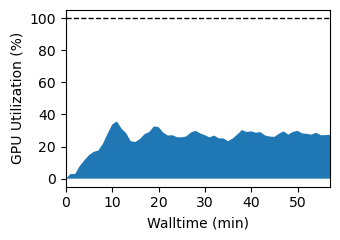

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.fill_between(system_average['time'] / 60, system_average['gpu_use'] / (num_nodes * 4) * 100)

ax.set_xlim([0, system_average['time'].max() / 60])
ax.plot(ax.get_xlim(), [100] * 2, 'k--', lw=1.)

ax.set_xlabel('Walltime (min)')
ax.set_ylabel('GPU Utilization (%)')
fig.tight_layout()
fig.savefig('figures/gpu-utilization.png', dpi=320)

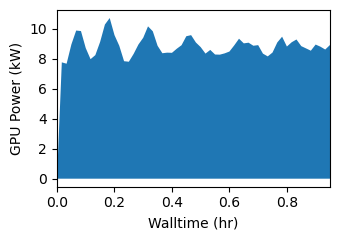

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.fill_between(system_average['time'] / 3600, system_average['gpu_power'] / 1000)

ax.set_xlim([0, system_average['time'].max() / 3600])

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('GPU Power (kW)')
fig.tight_layout()
fig.savefig('figures/gpu-utilization.png', dpi=320)

Compute node ids so we can associate nodes with tasks

In [25]:
utilization['node_id'] = utilization['node'].apply(node_names.index)

Summarize task and utilization

In [26]:
utilization_matrix = np.ones((num_nodes * 4, len(times), 4))  # Time interval, GPU ID, (RGBA) where RGB are defined by task and A by color

In [27]:
chosen_rgb = np.array([colors.to_rgb(c) for c in color_map])
for (node_id, local_rank), group in tasks.groupby(['node_id', 'local_rank']):
    # Get the GPUs this covers
    rows = node_id * 4 + local_rank
    gpu_ids = [local_rank]
    
    # Get the task ID as a function of time
    task_types = [(0, -1)]  # (start_time, task_id)
    task_types.extend(zip(group['start_time'], group['task_id']))
    task_types.extend(zip(group['end_time'], [-1] * len(group)))  # -1 means Idle
    time, task_id = zip(*sorted(task_types))
    task_type_fn = interp1d(time, task_id, kind='previous', fill_value=-1, bounds_error=False)
    
    # Compute the task type at each time interval
    task_type = np.array(task_type_fn(times), dtype=int)
    
    # Map the task type to color
    utilization_matrix[rows, :, :3] = chosen_rgb[task_type + 1][None, :, :]
    
    # Make the alpha channel the color
    util_data = utilization.query(f'node_id=={node_id}')
    for gpu_id in gpu_ids:
        util_fun = interp1d(util_data['time'], util_data['gpu_use'].apply(lambda x: x[gpu_id] / 100), fill_value=0, bounds_error=False)
        utilization_matrix[node_id * 4 + gpu_id, :, -1] = util_fun(times)

Plot utilization.

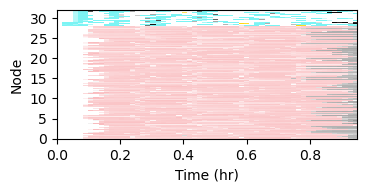

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

ax.matshow(utilization_matrix, origin='lower', aspect='auto',
           extent=[0, times.max() / 3600, 0, num_nodes])
ax.xaxis.tick_bottom()

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Node')

bbox_kwargs = dict(edgecolor='k', facecolor='w', alpha=0.95)
ax.annotate('Generation', (2.8, 5), xytext=(2.1, 15),
            bbox=bbox_kwargs, arrowprops=dict(width=0.5, headwidth=1.5, headlength=4),
           fontsize=7)
#ax.set_xlim([0, 3.])
#ax.set_ylim([9, 12])

fig.tight_layout(pad=0.1)
fig.savefig('figures/utilization-by-GPU.png', dpi=320)